In [2]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.test.is_built_with_cuda()

True

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
import pickle

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential,load_model
from keras.layers import Input, Embedding
from keras.layers import Dense, Bidirectional
from keras.layers.recurrent import LSTM
import keras.metrics as metrics
import itertools
from tensorflow.python.keras.utils.data_utils import Sequence
from decimal import Decimal
from keras import backend as K
from keras.layers import Conv1D,MaxPooling1D,Flatten,Dense

# Data Fetching

In [3]:
A1=np.empty((0,5),dtype='float32')
U1=np.empty((0,7),dtype='float32')
node=['150','149','147','144','142','140','136','61']
mon=['Apr','Mar','Aug','Jun','Jul','Sep','May','Oct']
for j in node:
  for i in mon:
    inp= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[1,2,3,15,16])
    out= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[5,6,7,8,17,18,19])
    
    inp=np.array(inp,dtype='float32')
    out=np.array(out,dtype='float32')
    
    A1=np.append(A1, inp, axis=0)
    U1=np.append(U1, out, axis=0)

print(A1)
print(U1)


[[1.50000e+02 1.90401e+05 7.25000e+02 2.75500e+01 8.03900e+01]
 [1.50000e+02 1.90401e+05 8.25000e+02 2.75600e+01 8.03300e+01]
 [1.50000e+02 1.90401e+05 9.25000e+02 2.75800e+01 8.02400e+01]
 ...
 [6.10000e+01 1.91020e+05 1.94532e+05 2.93700e+01 7.52100e+01]
 [6.10000e+01 1.91020e+05 1.94632e+05 2.93500e+01 7.52700e+01]
 [6.10000e+01 1.91020e+05 1.94732e+05 2.93400e+01 7.53000e+01]]
[[ 28.     3.   -52.   ...  16.97  19.63  20.06]
 [ 28.    15.   -53.   ...  16.63  19.57  23.06]
 [ 31.    16.   -55.   ...  17.24  19.98  20.24]
 ...
 [ 76.    12.   -76.   ...   3.47   3.95   4.35]
 [ 75.    13.   -76.   ...   3.88   4.33   4.42]
 [ 76.    12.   -75.   ...   3.46   4.07   4.28]]


# Min Max Scaler

In [4]:
from sklearn.decomposition import PCA
import warnings
scaler_obj1=PCA()
scaler_obj2=PCA()
X1=scaler_obj1.fit_transform(A1)
Y1=scaler_obj2.fit_transform(U1)

warnings.filterwarnings(action='ignore', category=UserWarning)

X1=X1[:,np.newaxis,:]
Y1=Y1[:,np.newaxis,:]

In [5]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Model

In [6]:
model1 = Sequential()
model1.add(keras.Input(shape=(1,5)))
model1.add(tf.keras.layers.LSTM(7,activation="tanh",use_bias=True,kernel_initializer="glorot_uniform",bias_initializer="zeros"))
model1.add(Dense(7))
model1.add(keras.layers.BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,
                                beta_initializer="zeros",gamma_initializer="ones",
                                moving_mean_initializer="zeros",moving_variance_initializer="ones",trainable=True))
model1.add(keras.layers.ReLU())
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy',metrics=['accuracy','mse','mae',rmse])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7)                 364       
                                                                 
 dense (Dense)               (None, 7)                 56        
                                                                 
 batch_normalization (BatchN  (None, 7)                28        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 7)                 0         
                                                                 
Total params: 448
Trainable params: 434
Non-trainable params: 14
_________________________________________________________________


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

In [8]:
model_fit8 = model1.fit(x_train,y_train,batch_size=256,epochs=50, validation_split=0.1)

Epoch 1/50
4563/4563 [==============================] - 65s 13ms/step - loss: 32.2965 - accuracy: 0.0553 - mse: 2296468736.0000 - mae: 96.7108 - rmse: 197.1048 - val_loss: -82.6092 - val_accuracy: 0.0552 - val_mse: 30784.3691 - val_mae: 72.9511 - val_rmse: 137.5164
Epoch 2/50
4563/4563 [==============================] - 58s 13ms/step - loss: 39.6923 - accuracy: 0.0552 - mse: 2296447488.0000 - mae: 96.7025 - rmse: 197.1037 - val_loss: -83.4331 - val_accuracy: 0.0552 - val_mse: 30784.2891 - val_mae: 72.9396 - val_rmse: 137.5159
Epoch 3/50
4563/4563 [==============================] - 55s 12ms/step - loss: 30.9430 - accuracy: 0.0551 - mse: 2296455168.0000 - mae: 96.6924 - rmse: 197.1042 - val_loss: -83.3271 - val_accuracy: 0.0550 - val_mse: 30784.3848 - val_mae: 72.9315 - val_rmse: 137.5164
Epoch 4/50
4563/4563 [==============================] - 56s 12ms/step - loss: 43.7148 - accuracy: 0.0549 - mse: 2296446464.0000 - mae: 96.6848 - rmse: 197.1031 - val_loss: -83.7202 - val_accuracy: 0.054

Epoch 32/50
4563/4563 [==============================] - 56s 12ms/step - loss: 45.0594 - accuracy: 0.0534 - mse: 2296460800.0000 - mae: 96.6413 - rmse: 197.0925 - val_loss: -88.7950 - val_accuracy: 0.0554 - val_mse: 30782.4766 - val_mae: 72.8837 - val_rmse: 137.5035
Epoch 33/50
4563/4563 [==============================] - 55s 12ms/step - loss: 42.5598 - accuracy: 0.0534 - mse: 2296456960.0000 - mae: 96.6408 - rmse: 197.0926 - val_loss: -88.5490 - val_accuracy: 0.0554 - val_mse: 30782.6191 - val_mae: 72.8848 - val_rmse: 137.5042
Epoch 34/50
4563/4563 [==============================] - 56s 12ms/step - loss: 42.3962 - accuracy: 0.0533 - mse: 2296472832.0000 - mae: 96.6406 - rmse: 197.0923 - val_loss: -88.8929 - val_accuracy: 0.0554 - val_mse: 30782.4258 - val_mae: 72.8830 - val_rmse: 137.5031
Epoch 35/50
4563/4563 [==============================] - 56s 12ms/step - loss: 47.9550 - accuracy: 0.0532 - mse: 2296445440.0000 - mae: 96.6400 - rmse: 197.0914 - val_loss: -89.0165 - val_accuracy: 0

In [9]:
model1.evaluate(x_test,y_test)

13518/13518 [==============================] - 81s 6ms/step - loss: -79.3165 - accuracy: 0.0559 - mse: 1432089.6250 - mae: 74.2764 - rmse: 141.0446


[-79.3165054321289,
 0.05594056844711304,
 1432089.625,
 74.27635192871094,
 141.0446014404297]

In [10]:
model1.evaluate(x_train,y_train)

40554/40554 [==============================] - 256s 6ms/step - loss: 34.5807 - accuracy: 0.0554 - mse: 2066738048.0000 - mae: 94.2606 - rmse: 191.1279


[34.58066940307617,
 0.05544565990567207,
 2066738048.0,
 94.26062774658203,
 191.12794494628906]

In [11]:
df1=pd.DataFrame(model_fit8.history['loss'],columns=["Loss"])
df1=df1.join(pd.DataFrame(model_fit8.history["val_loss"],columns=["Val Loss"]))
df1=df1.join(pd.DataFrame(model_fit8.history["accuracy"],columns=['Accuracy']))
df1=df1.join(pd.DataFrame(model_fit8.history["val_accuracy"],columns=['Val Accuracy']))
df1=df1.join(pd.DataFrame(model_fit8.history["mse"],columns=['MSE']))
df1=df1.join(pd.DataFrame(model_fit8.history["val_mse"],columns=['Val MSE']))
df1=df1.join(pd.DataFrame(model_fit8.history["mae"],columns=['MAE']))
df1=df1.join(pd.DataFrame(model_fit8.history["val_mae"],columns=['Val MAE']))
df1=df1.join(pd.DataFrame(model_fit8.history["rmse"],columns=['RMSE']))
df1=df1.join(pd.DataFrame(model_fit8.history["val_mse"],columns=['Val RMSE']))
df1

,Loss,Val Loss,Accuracy,Val Accuracy,MSE,Val MSE,MAE,Val MAE,RMSE,Val RMSE
0,32.296535,-82.609222,0.055270,0.055222,2.296469e+09,30784.369141,96.710831,72.951057,197.104828,30784.369141
1,39.692318,-83.433136,0.055186,0.055172,2.296447e+09,30784.289062,96.702538,72.939590,197.103745,30784.289062
2,30.943045,-83.327110,0.055087,0.054962,2.296455e+09,30784.384766,96.692406,72.931511,197.104202,30784.384766
3,43.714767,-83.720154,0.054924,0.054680,2.296446e+09,30784.314453,96.684784,72.926964,197.103088,30784.314453
4,37.623192,-84.476433,0.054731,0.054370,2.296447e+09,30784.027344,96.682266,72.924706,197.102936,30784.027344
5,38.353409,-84.874901,0.054591,0.054760,2.296469e+09,30783.910156,96.680443,72.922661,197.102478,30783.910156
6,43.791801,-84.956352,0.054539,0.054595,2.296469e+09,30783.927734,96.678978,72.923256,197.101013,30783.927734
7,32.578888,-85.289925,0.054353,0.054235,2.296465e+09,30783.830078,96.679054,72.923195,197.100891,30783.830078
8,32.665302,-85.825378,0.054081,0.053886,2.296463e+09,30783.636719,96.678841,72.922195,197.099930,30783.636719
9,40.118526,-85.936081,0.053956,0.053702,2.296456e+09,30783.626953,96.678581,72.921913,197.099564,30783.626953


In [12]:
df1.to_excel("LSTM.xlsx")

# Saving Model as File

In [13]:
print(x_test.shape)

(432571, 1, 5)


In [14]:
model_json = model1.to_json()
with open("lstm_tanh.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("lstm_tanh.h5")
print("Saved model to disk")

Saved model to disk


In [15]:
from keras.models import model_from_json
json_file = open('lstm_tanh.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("lstm_tanh.h5")
print("Loaded model from disk")
loaded_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy',metrics=['accuracy','mse','mae',rmse])

Loaded model from disk


In [16]:
print(loaded_model.history)

None


# Error Analysis

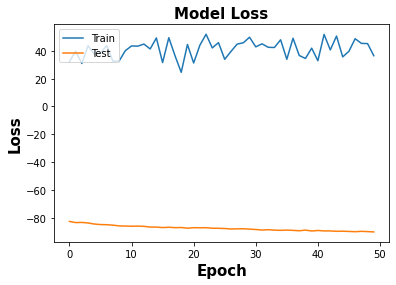

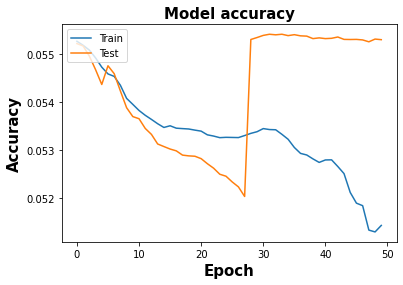

In [17]:
# summarize history for loss
plt.plot(model_fit8.history['loss'])
plt.plot(model_fit8.history['val_loss'])
plt.title('Model Loss',fontweight ='bold',fontsize = 15)
plt.ylabel('Loss',fontweight ='bold',fontsize = 15)
plt.xlabel('Epoch',fontweight ='bold',fontsize = 15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(model_fit8.history['accuracy'])
plt.plot(model_fit8.history['val_accuracy'])
plt.title('Model accuracy',fontweight ='bold',fontsize = 15)
plt.ylabel('Accuracy',fontweight ='bold',fontsize = 15)
plt.xlabel('Epoch',fontweight ='bold',fontsize = 15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
#Creating csv file of prediction

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

y_test_pred=loaded_model.predict(x_test)
y_test_pred

array([[0.44651064, 0.8149599 , 0.45574972, ..., 0.        , 0.        ,
        0.        ],
       [0.44651064, 0.8149599 , 0.45574972, ..., 0.        , 0.        ,
        0.        ],
       [0.44651064, 0.8149599 , 0.45574972, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.02895683,
        0.        ],
       [0.44651064, 0.8149599 , 0.45574972, ..., 0.        , 0.        ,
        0.        ],
       [0.44651064, 0.8149599 , 0.45574972, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [20]:
y_test

array([[[-5.5306183e+01,  3.0651539e+01,  2.6809818e+02, ...,
         -3.2125660e+01, -6.0041463e-01,  3.5637581e-01]],

       [[-4.0849674e+01, -3.2327366e+01,  4.0117168e+01, ...,
         -1.6759521e+01, -4.3478742e-01, -4.7449446e-01]],

       [[-5.3128677e+01,  6.3768907e+00, -5.4489349e+02, ...,
          2.2194275e+01,  4.7399120e+00, -9.3144459e-01]],

       ...,

       [[-8.7860565e+01, -3.0838274e+01, -4.4087744e+02, ...,
          6.9052582e+01,  3.2712939e-01, -9.7863328e-01]],

       [[-5.1226246e+01,  1.9645956e+01,  1.7010298e+02, ...,
         -2.2718235e+01, -1.5850252e+00, -2.5478810e-01]],

       [[-9.5646217e+01, -6.0683804e+01,  1.5412691e+02, ...,
         -2.9311705e+01, -8.5079241e-01,  3.8455275e-01]]], dtype=float32)

In [21]:
y_test=y_test[:,0]

In [22]:
from numpy import savetxt
savetxt('lstm_y_test_pred.csv', y_test_pred[:1001], delimiter=',')

In [23]:
from numpy import savetxt
savetxt('lstm_y_test.csv', y_test[:1001], delimiter=',')

In [ ]:
#completed